In [47]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [48]:
client = bnb_client(tld='US')

def get_data(symbol,freq,start_ts = '2020-01-01',end_ts='2025-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

In [49]:
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 
            'XRPUSDT', 'MATICUSDT', 'DOGEUSDT']
freq = '4h'


px = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

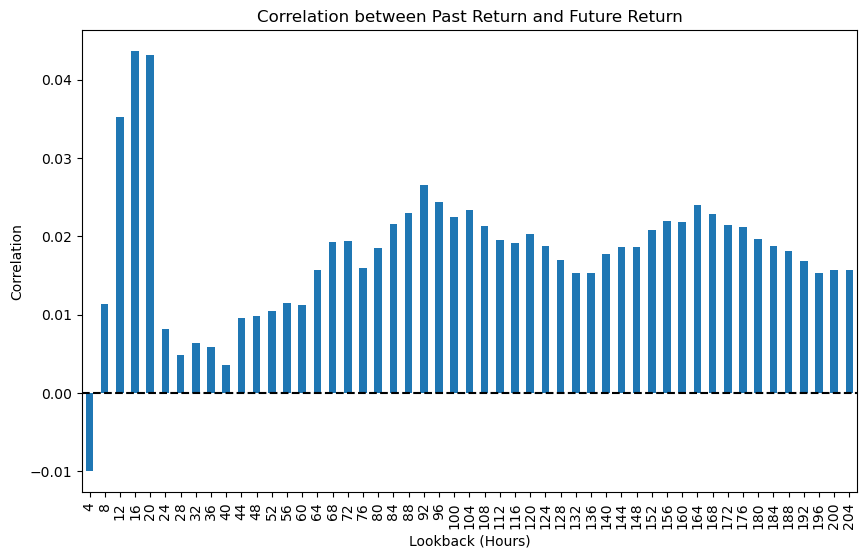

In [50]:
# Test different time horizons

momentum = {}

periods = range(1,52)

for p in periods:
    
    window = ret.rolling(p).mean()
    nextReturn = ret.shift(-1)
    
    # Find valid periods where a nextReturn is found
    valid = window.stack().dropna().index.intersection(nextReturn.stack().dropna().index)
    
    window = window.stack().loc[valid]
    nextReturn = nextReturn.stack().loc[valid]
    
    # Calculate correlation between window and the next 4 hours
    corr = window.corr(nextReturn)
    momentum[p*4] = corr 
    
pd.Series(momentum).plot.bar(title="Correlation between Past Return and Future Return", ylabel="Correlation", xlabel="Lookback (Hours)", figsize=(10,6))
plt.axhline(0, color='black', linestyle='--')
plt.show()

,4,8,12,16,20
2020-12-31,-5.132816,-4.676621,-3.744353,-1.757788,-0.053536
2021-12-31,0.146468,1.779447,3.562020,3.764754,3.561924
2022-12-31,-1.587375,-0.633504,-0.343896,1.284873,1.236472
2023-12-31,0.073572,0.697717,0.177981,1.483348,-0.206132
2024-12-31,-1.057051,0.325153,1.890635,2.080335,2.304243
2025-12-31,-0.274782,1.980574,0.806547,1.234564,-0.195163


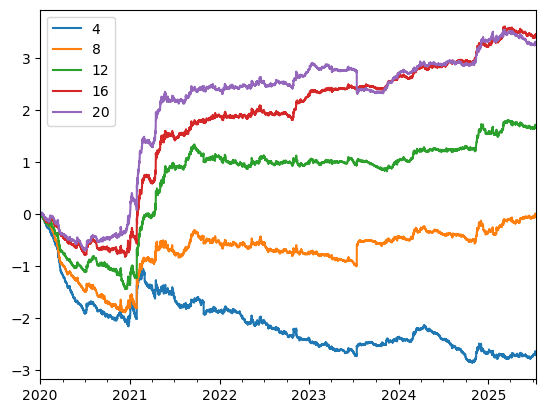

In [56]:
# It looks like there's peaks in correlation every 24 hours (crypto is traded at similar times?)

# Let's look at a simple momentum strategy on the last 20 hours essentially trading at the same 4 hours every day 
# Based on the last 20 hours using a rank-demean strategy

l = range(1,6)
strat_returns = {}

for x in l:

    past = ret.rolling(x).mean().rank()
    
    demeaned = past.subtract(past.mean(axis=1), axis=0)
    weights = demeaned.divide(demeaned.abs().sum(axis=1), axis=0)
    
    strat_returns[x*4] = (weights.shift()*ret).sum(1)
    

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)
strat_returns.cumsum().plot()
sr

In [6]:
# Some of these returns and sharpe ratios actually weren't terrible but let's experiment with some other ways 
# that we can normalize our data 

<AxesSubplot:>

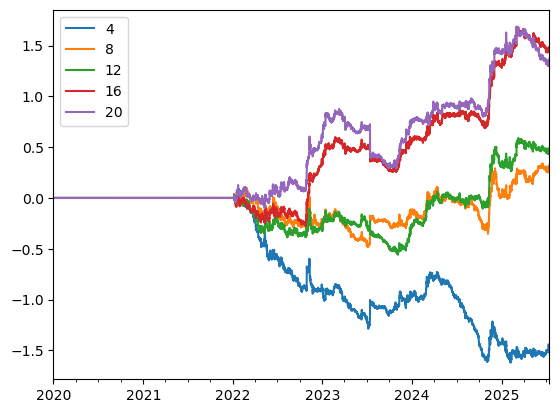

In [8]:
# Zscore normalization
l = range(1,6)
strat_returns = {}

for x in l:
    past = ret.rolling(x).mean().dropna()

    
    z = past.apply(zscore, axis=1)
    weights = z.divide(z.abs().sum(axis=1), axis=0)
    
    strat_returns[x*4] = (weights.shift()*ret).sum(1)

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


strat_returns.cumsum().plot()


<AxesSubplot:>

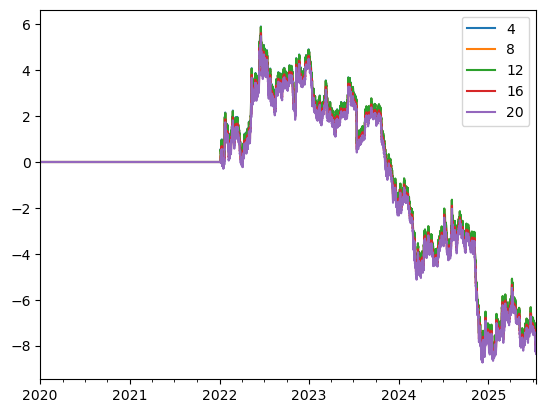

In [12]:
# Soft max normalization
l = range(1,6)
strat_returns = {}

def softmax(x):
    e_x = np.exp(x.subtract(x.mean(axis=1), axis=0))
    return e_x.divide(e_x.sum(axis=1), axis=0)

for x in l:
    past = ret.rolling(x).mean().dropna()

    weights = softmax(past)
    weights = weights.subtract(0.5) * 2
    
    strat_returns[x*4] = (weights.shift()*ret).sum(1)
    

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)

strat_returns.cumsum().plot()


4    -0.431025
8     0.301001
12    1.395834
16    1.672592
20    1.567615
dtype: float64

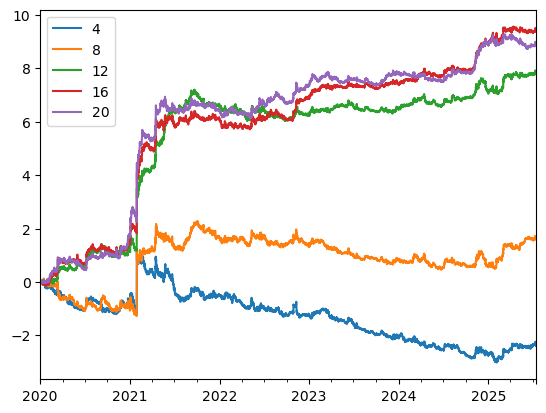

In [44]:
# Signal weighted normalization
l = range(1,6)
strat_returns = {}

for x in l:
    past = ret.rolling(x, min_periods=x).mean()

    
    
    weights = past.divide(past.abs().sum(1),0)
    
    strat_returns[x*4] = (weights.shift()*ret).sum(1)

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


strat_returns.cumsum().plot()
sharpe